In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import random
import scipy.stats
import math
import statistics
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import adfuller
from statsmodels.stats import diagnostic
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels

import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv(r"london_weather.csv")
df = df.drop(np.arange(3040,len(df)))
df = df[["date","mean_temp"]]
df = df.dropna()
df.insert(0,"index",np.arange(len(df)))
df = df.reset_index()
df.set_index("index")
df

,level_0,index,date,mean_temp
0,0,0,19790101,-4.1
1,1,1,19790102,-2.6
2,2,2,19790103,-2.8
3,3,3,19790104,-2.6
4,4,4,19790105,-0.8
...,...,...,...,...
3035,3035,3035,19870424,14.8
3036,3036,3036,19870425,15.0
3037,3037,3037,19870426,15.1
3038,3038,3038,19870427,15.6


In [3]:
t = df["index"]
temp = df["mean_temp"]

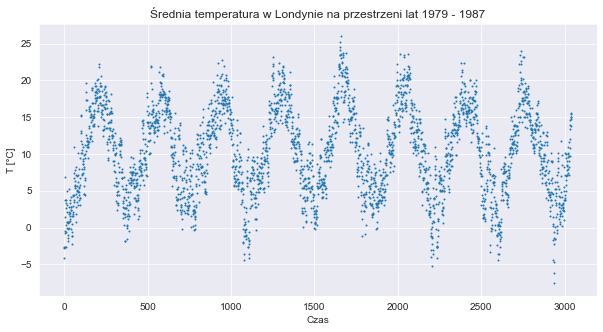

In [4]:
plt.figure(figsize = (10,5))
plt.scatter(t,temp,s=1)
plt.xlabel("Czas")
plt.ylabel("T [°C]")
plt.title("Średnia temperatura w Londynie na przestrzeni lat 1979 - 1987")

plt.savefig('obrazki/plot1.pdf', format='pdf')

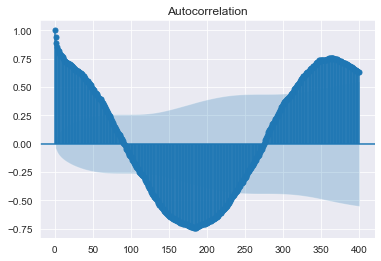

In [5]:
h = 400
plot_acf(temp, lags=h, adjusted=True)
plt.savefig('obrazki/acf1.png', format='png')

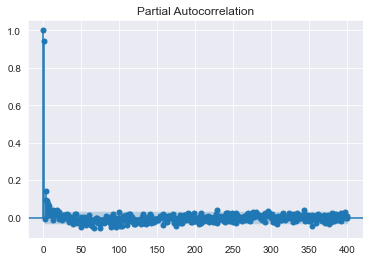

In [6]:
plot_pacf(temp, lags=h, method='ywm')
plt.savefig('obrazki/pacf1.png', format='png')

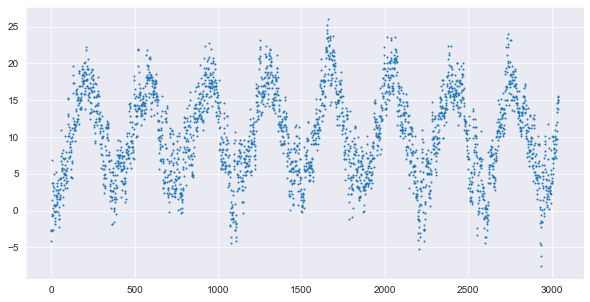

In [7]:
train = df
test = df.drop(train.index)
plt.figure(figsize = (10,5))
plt.scatter(train["index"],train["mean_temp"],s=1)

train_t = train["index"]
train_temp = train["mean_temp"]

In [8]:
#dekompozycja liniowości
a,b = np.linalg.lstsq(np.vstack([train_t, np.ones(len(train_t))]).T, train_temp, rcond=None)[0]

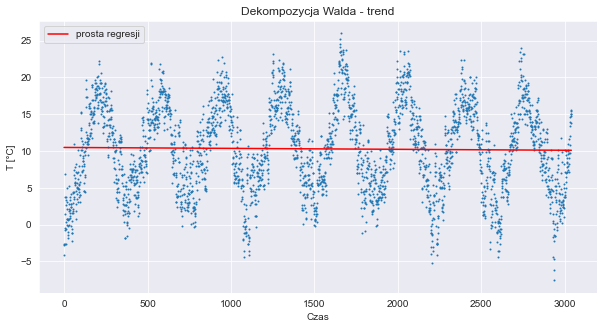

In [9]:
plt.figure(figsize = (10,5))
plt.scatter(train_t,train_temp,s=1)
plt.plot(train_t,a*train_t+b,"r",label="prosta regresji")

plt.xlabel("Czas")
plt.ylabel("T [°C]")
plt.title("Dekompozycja Walda - trend")
plt.legend(loc="upper left")

plt.savefig('obrazki/plot2.pdf', format='pdf')

In [10]:
a, b

(-0.00012707255017574176, 10.486573582097298)

In [11]:
train_temp_2 = []
for i in range(len(train)):
    train_temp_2.append(train_temp[i] - a*train_t[i] - b)

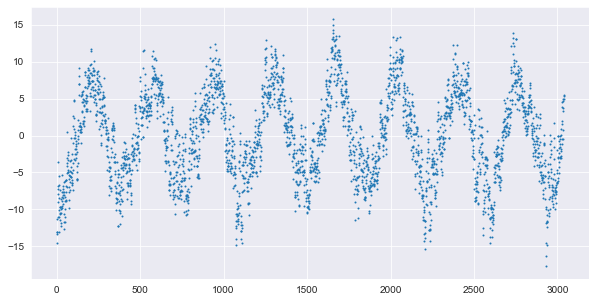

In [12]:
plt.figure(figsize = (10,5))
plt.scatter(train_t,train_temp_2,s=1)

In [13]:
def func(t, c, d, e):
    return c* np.sin(d*t + e)

Q = np.quantile(train_temp_2, 0.9)
p0 = [Q,1/(350/1/(2*np.pi)),np.random.random()]
c_est, d_est, e_est = sp.optimize.curve_fit(func, xdata = train_t, ydata = train_temp_2,p0=p0,bounds = ((Q,0,0),(40,np.inf,10)))[0]

In [14]:
c_est, d_est, e_est

(7.6647057756085255, 0.01718140260716165, 4.307798428249905)

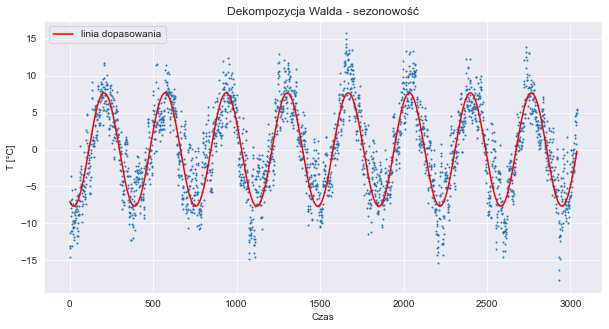

In [15]:
plt.figure(figsize = (10,5))
plt.scatter(train_t,train_temp_2,s=1)
plt.plot(train_t,func(train_t,c_est, d_est, e_est),"r",label = "linia dopasowania")

plt.xlabel("Czas")
plt.ylabel("T [°C]")
plt.title("Dekompozycja Walda - sezonowość")
plt.legend(loc="upper left")

plt.savefig('obrazki/plot3.pdf', format='pdf')

In [16]:
train_temp_3 = []
for i in range(len(train)):
    train_temp_3.append(train_temp_2[i] - c_est* np.sin(d_est*train_t[i] + e_est))

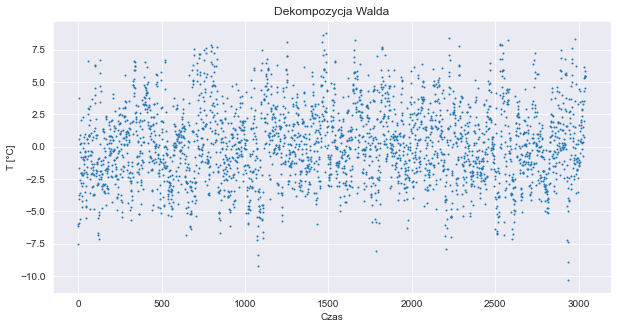

In [17]:
plt.figure(figsize = (10,5))
plt.scatter(train_t,train_temp_3,s=1)
plt.xlabel("Czas")
plt.ylabel("T [°C]")
plt.title("Dekompozycja Walda")

plt.savefig('obrazki/plot4.pdf', format='pdf')

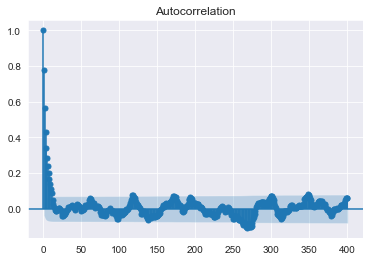

In [18]:
plot_acf(train_temp_3, lags=h, adjusted=True)
plt.savefig('obrazki/acf2.pdf', format='pdf')

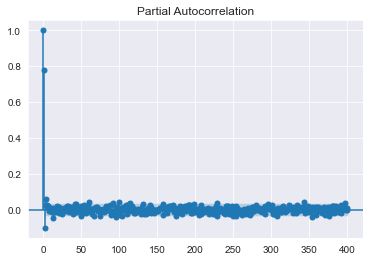

In [19]:
plot_pacf(train_temp_3, lags=h, method='ywm')
plt.savefig('obrazki/pacf2.pdf', format='pdf')

# Modelowanie danych przy pomocy ARMA

In [20]:
data = train_temp_3

df1 = pd.DataFrame()
ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 10
max_q = 10

for p in range(0, max_p):
    for q in range(0, max_q):
        model = ARIMA(data, order=(p, 0, q))
        model_fit = model.fit()
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df1['p']    = ps
df1['q']    = qs
df1['AIC']  = AIC
df1['BIC']  = BIC
df1['HQIC'] = HQIC

C:\Users\zleko\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\zleko\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\zleko\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\zleko\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\zleko\anaconda3\lib\site-packages\statsmodels\base\model.py:566: 

C:\Users\zleko\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\zleko\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\zleko\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\zleko\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\zleko\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximu

In [21]:
df1.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
44,4,4,12396.503197,12456.699325,12418.141000
66,6,6,12398.261271,12482.535850,12428.554194
33,3,3,12398.462068,12446.618971,12415.772311
31,3,1,12398.593310,12434.710986,12411.575991
56,5,6,12398.972109,12477.227075,12427.101252


In [22]:
df1.sort_values(by='BIC').head()

,p,q,AIC,BIC,HQIC
11,1,1,12406.501357,12430.579808,12415.156478
30,3,0,12401.401320,12431.499384,12412.220222
12,1,2,12403.264569,12433.362633,12414.083470
31,3,1,12398.593310,12434.710986,12411.575991
20,2,0,12411.177540,12435.255991,12419.832661


In [23]:
df1.sort_values(by='HQIC').head()

,p,q,AIC,BIC,HQIC
31,3,1,12398.593310,12434.710986,12411.575991
30,3,0,12401.401320,12431.499384,12412.220222
22,2,2,12399.307344,12435.425021,12412.290026
13,1,3,12400.685268,12436.802945,12413.667950
12,1,2,12403.264569,12433.362633,12414.083470


In [24]:
p, q = 1, 1

model = ARIMA(train_temp_3, order=(p, 0, q)).fit()
print(model.summary())

resid = model.resid
params = model.params

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3040
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -6199.251
Date:                Thu, 09 Feb 2023   AIC                          12406.501
Time:                        09:34:57   BIC                          12430.580
Sample:                             0   HQIC                         12415.156
                               - 3040                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2049      0.142      1.447      0.148      -0.073       0.482
ar.L1          0.7229      0.016     45.998      0.000       0.692       0.754
ma.L1          0.1472      0.022      6.703      0.0

[]

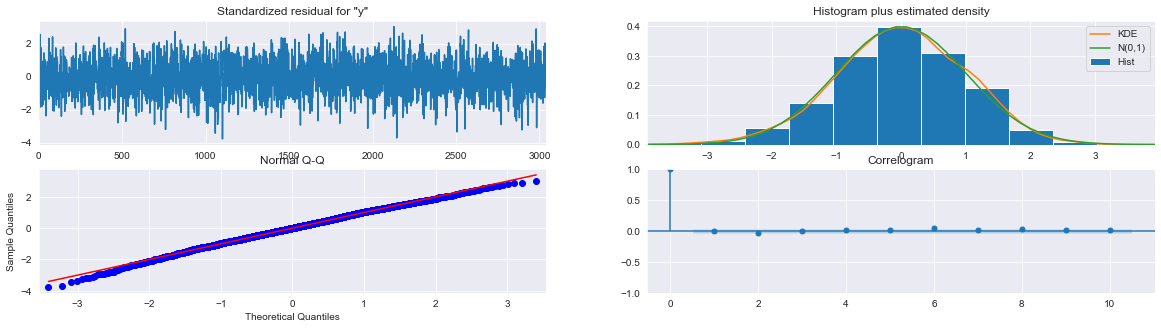

In [25]:
model.plot_diagnostics(0,figsize=(20,5))
plt.plot()

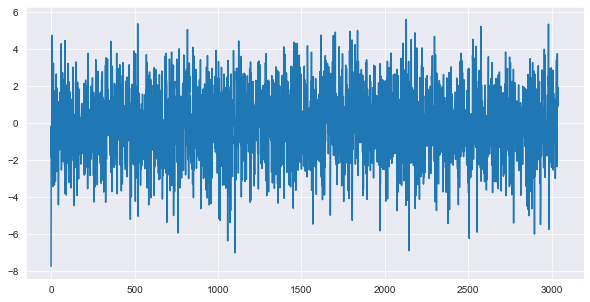

In [26]:
plt.figure(figsize = (10,5))
plt.plot(train_t,resid)
plt.savefig('obrazki/res.png', format='png')

In [27]:
sp.stats.ttest_1samp(resid, popmean=0)

Ttest_1sampResult(statistic=0.03328993234158584, pvalue=0.9734455683133688)

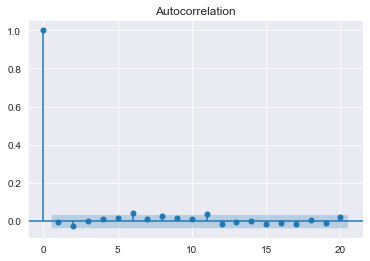

In [28]:
h = 20
plot_acf(resid, lags=h, adjusted=True)
plt.savefig('obrazki/acf_res.png', format='png')

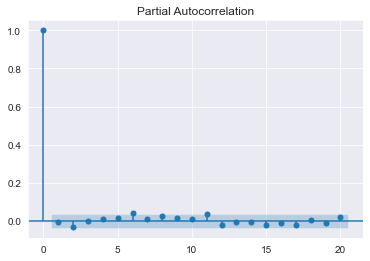

In [29]:
plot_pacf(resid, lags=h, method='ywm')
plt.savefig('obrazki/pacf_res.png', format='png')

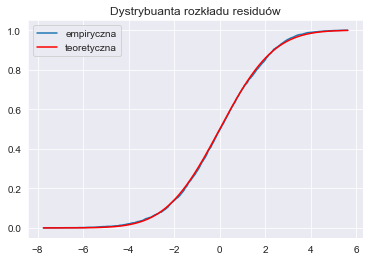

In [35]:
F = statsmodels.distributions.empirical_distribution.ECDF(resid)
plt.plot(np.arange(min(resid), max(resid), 0.01), F(np.arange(min(resid), max(resid), 0.01)), label="empiryczna")
plt.plot(np.arange(min(resid), max(resid), 0.01), scipy.stats.norm.cdf(np.arange(min(resid), max(resid), 0.01), scale=np.std(resid)), label="teoretyczna",color="r")
plt.legend()
plt.title("Dystrybuanta rozkładu residuów")
plt.savefig('obrazki/res_dist.png', format='png')

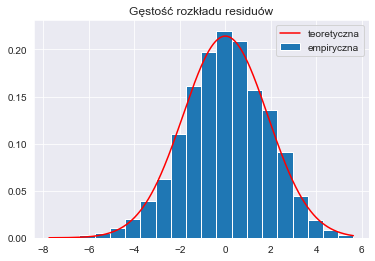

In [34]:
plt.hist(resid, density=True, bins=20, label="empiryczna")
plt.plot(np.arange(min(resid), max(resid), 0.01), scipy.stats.norm.pdf(np.arange(min(resid), max(resid), 0.01), scale=np.std(resid)), label="teoretyczna",color="r")
plt.legend()
plt.title("Gęstość rozkładu residuów")
plt.savefig('obrazki/res_pdf.png', format='png')

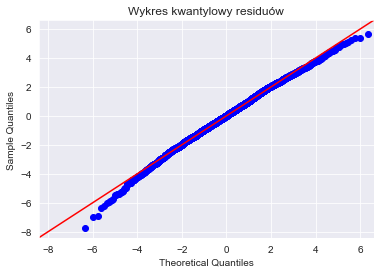

In [33]:
statsmodels.graphics.gofplots.qqplot(resid, scale=np.std(resid), line="45")
plt.title("Wykres kwantylowy residuów")
plt.savefig('obrazki/res_qq.png', format='png')